# Image classification  - Kaggle Plant Seedling Classification

## Initial Import of Modules

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Here we import the libraries we need

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "data/plant-seedlings-classification/"

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

#### Steps im following

1. Enable data augmentation, and precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Train a little more with new file size
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

## The Dataset 

This is provided from kaggle in the plant-seedlings-classfication competition. The .zip files provided are in test and train foldes with the train folder having subfolders for each class (Keras style).

Lets first download the data. Im using the official kaggle CLI https://github.com/Kaggle/kaggle-api

### Download and unzip dataset

In [ ]:
# !mkdir $PATH
# !kaggle competitions download -c plant-seedlings-classification -p ~/github/fastai/courses/dl1/$PATH

Unzip all files provided by Kaggle in to directory and then remove the .zip files

In [ ]:
# !unzip -q '{PATH}*.zip' -d {PATH}

In [ ]:
# !rm -r {PATH}*.zip

In [ ]:
# os.listdir(PATH)

### Create CSV Reference file for lables

When running this through previously i found that 2 classes were always getting lots of mis-classifications (Black-grass & Loose Silky-bent). I also noted that Black-grass was under represented compared to Loose Silky-bent (Black-grass=263 ; Loose Silky-bent=654. So i duplicated all the images in the Black-grass folder (appending _2 to the file name). I did this via bash before the next steps


Lets create a csv reference file so we can use the much easier `ImageClassifierData.from_csv()` option

In [ ]:
# !for file in $PATH/Black-grass/*.png; do cp "$file" "${file%.png}_2.png"; done

In [ ]:
# from glob2 import glob
# import pandas as pd

# df = pd.DataFrame(columns=["file", "species"])

# for image in glob(f'{PATH}train/**/*.png'):
#     dir_ = image.split('/')
#     file_, species = dir_[-1], dir_[-2]

#     df = df.append({
#         "file": file_,
#         "species": species.replace(" ", "_")
#         }, ignore_index=True)

# df.to_csv(f'{PATH}labels.csv', index=False)

Read in our dataframe and view the structure

In [7]:
labels_csv = f'{PATH}labels.csv'
labels_df = pd.read_csv(labels_csv)

Lets have a look at the first few records in the labels_csv dataframe

In [8]:
labels_df.head(10)

,file,species
0,d04eff450.png,Charlock
1,6d8b4041a.png,Charlock
2,ec48facfa.png,Charlock
3,8f4d248bd.png,Charlock
4,6a3339ef1.png,Charlock
5,09f038ce4.png,Charlock
6,67e37de9b.png,Charlock
7,d733b32d8.png,Charlock
8,1fb63feb5.png,Charlock
9,410598462.png,Charlock


Now move all the images from under the class subfolders into the root train folder

In [ ]:
# !mv {PATH}train/**/*.png {PATH}train/

Remove all the empty class subfolders from train/

In [ ]:
# !rm -r {PATH}train/**/

Lets view the distribution of the classes a a pivot. Note the orginal Black-grass category only had 236 images.

In [9]:
labels_df.pivot_table(index = 'species', aggfunc = len).sort_values('file', ascending = False)

,file
species,
Loose_Silky-bent,654
Common_Chickweed,611
Black-grass,526
Scentless_Mayweed,516
Small-flowered_Cranesbill,496
Fat_Hen,475
Charlock,390
Sugar_beet,385
Cleavers,287


### Make validation indexes

In [11]:
# Create validation indexes
# n = len(list(open(labels_csv)))-1
# val_idxs = get_cv_idxs(n)

In [ ]:
val_idxs = [0]

## Transformations

Defined the below function. By defining it this way it allows us to change the batch size or image size during the training without duplicating the code everywhere.

In [ ]:
arch=resnet50 # model architecture to use
sz=224 # image size
bs=64 # mini-batch size

In [12]:
def get_data(sz, bz):
    tfms = tfms_from_model(arch, # pass in architecture
                       sz, # image size
                       aug_tfms=transforms_top_down, # side_on for normal images top_down for satelite of photos taken from above
                       max_zoom=1.15)

    data = ImageClassifierData.from_csv(path = PATH,
                                    folder='train',
                                    csv_fname = labels_csv, # name of the labels reference file
                                    val_idxs = val_idxs, # validation indexes
                                    test_name = 'test',
                                    tfms = tfms, # transformations to apply
                                    bs = bs) #mini batch size
    return data if sz < 300 else data.resize(340, 'tmp')

In [13]:
data = get_data(sz, bs)

### Data set image resolutions

Take a look at the dataset distribution size of images.

(array([2544., 1061.,  247.,  115.,   23.,    7.,    6.,    6.,    1.,    1.]),
 array([  49. ,  409.3,  769.6, 1129.9, 1490.2, 1850.5, 2210.8, 2571.1, 2931.4, 3291.7, 3652. ]),
 <a list of 10 Patch objects>)

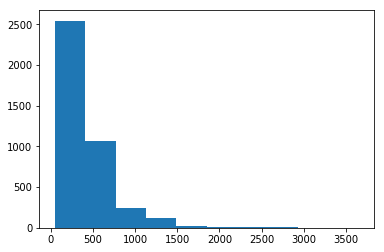

In [15]:
# # see distribution of all images
size_d = {k: Image.open(PATH + k).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz); col_sz = np.array(col_sz)
plt.hist(row_sz)

(array([1041.,  858.,  280.,  457.,  403.,  270.,  204.,  126.,   78.,   64.]),
 array([ 49., 144., 239., 334., 429., 524., 619., 714., 809., 904., 999.]),
 <a list of 10 Patch objects>)

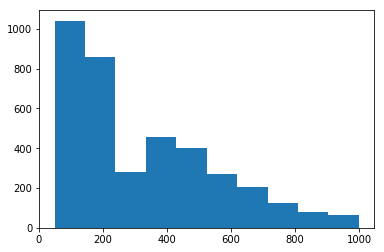

In [16]:
# # see distribution of images less than 1000 pixels
plt.hist(row_sz[row_sz < 1000])

## Model Build & Train

In [ ]:
# Uncomment the below if you need to reset your precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [ ]:
# shutil.rmtree(f'{PATH}model', ignore_errors=True)

In [17]:
# Create Learner
learn = ConvLearner.pretrained(arch,
                               data,
                               precompute=True)

100%|██████████| 16/16 [00:10<00:00,  1.49it/s]


### Find initial learning rate

In [18]:
# # use learn.lr_find to find the optimal learning rate
lrf = learn.lr_find()

 87%|████████▋ | 55/63 [00:01<00:00, 43.43it/s, loss=13.5]


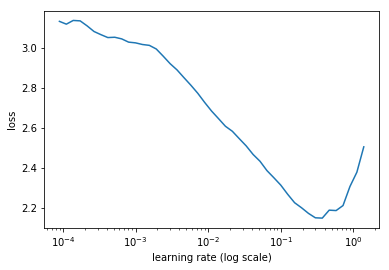

In [19]:
# #plot learing rate
learn.sched.plot()

In [21]:
lr = 1e-2

### Train the last layers with a few epochs

In [22]:
#Fit learner with a few epochs
learn.fit(lr, 3)

epoch      trn_loss   val_loss   accuracy                 
    0      1.185319   0.637752   0.793413  
    1      0.7621     0.506275   0.837325                  
    2      0.562358   0.464684   0.841317                  



[array([0.46468]), 0.8413173656263752]

In [23]:
#Fit learner with a few epochs
learn.fit(5e-3, 2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.382641   0.392996   0.868263  
    1      0.356106   0.374458   0.874251                  



[array([0.37446]), 0.8742514972439307]

In [24]:
learn.fit(5e-4, 2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.301022   0.372492   0.872255  
    1      0.300779   0.368471   0.878244                  



[array([0.36847]), 0.8782435132119946]

In [ ]:
# learn.save('inital_train')
learn.save('inital_train_all_data')
# learn.save('inital_train_swa')

### Train a little more with data augmentation enabled

In [ ]:
learn.precompute=False

In [ ]:
learn.fit(lr, 4, cycle_len=1)
# learn.fit(lr, 4, cycle_len=1, use_swa=True, swa_start=2)

In [ ]:
# learn.save('resnet50_224_ll') # training and validation sets
learn.save('resnet50_224_ll_all_data') # training and validation sets
# learn.save('resnet50_224_ll_swa') # training and validation sets

In [ ]:
# learn.load('resnet50_224_ll') # training and validation sets
learn.load('resnet50_224_ll_all_data') # training and validation sets
# learn.load('resnet50_224_ll_swa') # training and validation sets

Changes image size to 299x299 and trained a little more. Not sure how much of an impact this had in this case but seemed like a good idea to prevent any over fitting that may have occured in the previous few epochs

In [ ]:
learn.set_data(data = get_data(299, bs))

In [ ]:
learn.fit(lr, 4, cycle_len=1)
# learn.fit(lr, 4, cycle_len=1, use_swa=True, swa_start=2)

In [ ]:
# learn.save('resnet50_299_ll') # training and validation sets
learn.save('resnet50_299_ll_all_data') # training and validation sets
# learn.save('resnet50_299_ll_swa') # training and validation sets

In [ ]:
# learn.load('resnet50_299_ll') # training and validation sets
learn.load('resnet50_299_ll_all_data') # training and validation sets
# learn.load('resnet50_299_ll_swa') # training and validation sets

Swapped datasize back to 224 to continue training, not sure why really....just trial and error.

In [ ]:
learn.set_data(data = get_data(224, bs))

### Unfreeze earlier layers and train using differential learning rates SGD with restarts

In [ ]:
learn.unfreeze()

In [ ]:
lrf = learn.lr_find()

In [ ]:
#plot learing rate
learn.sched.plot()

In [ ]:
lr = 1e-3

Above learning rate looks good, i remember Jeremy mentioning that you should set the other learning rates between 3 and 10 times smaller each time. So i picked the below

In [ ]:
lrs=np.array([lr/9,lr/3,lr])
# lrs=np.array([lr/10,lr/3,lr])

In [ ]:
learn.fit(lr, 3, cycle_len=2, cycle_mult=3)
# learn.fit(lr, 4, cycle_len=2, cycle_mult=2, use_swa=True, swa_start=2, cycle_save_name="resnet50_224_swa")

In [ ]:
# learn.save('resnet50_224_final')
# learn.save('resnet50_224_final_all_data')
learn.save('resnet50_224_final_swa')

In [ ]:
# learn.load('resnet50_224_final')
# learn.load('resnet50_224_final_all_data')
learn.load('resnet50_224_final_swa')

## Test Time Augmentation on Validation Set

In [ ]:
log_preds,y = learn.TTA(True)
probs = np.mean(np.exp(log_preds),0)

In [ ]:
# validation accuracy after TTA
accuracy_np(probs, y)

## Analyzing Results

In [ ]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)

## Prepare Submission

### Look at sample submission file to determine file format

First we need to have a look at the sample submission file to see what layout the file needs to be in

In [ ]:
samp_sub_df = pd.read_csv(f'{PATH}sample_submission.csv')

From above we can see that we need a filename andthe predicted class `species`

In [ ]:
samp_sub_df.head()

We will run TTA with is_test=True to make sure it use the test set images

### Run TTA on the Test set and generate submission file

In [ ]:
log_preds_test, y = learn.TTA(n_aug=4, is_test=True)

We then get a 3 dimensional array out of TTA, this is 1 dimension for the original images and n for the augmented set of test images (default n_aug = 4)

In [ ]:
preds_test = np.mean( np.exp( log_preds_test ),0)
preds_test = np.argmax(preds_test, axis=1)

Make sure to replace the "\_" with spaces in the classes to resemble the original class names

In [ ]:
preds_classes = [data.classes[i].replace("_", " ") for i in preds_test]

In [ ]:
submission = pd.DataFrame({'file': os.listdir(f'{PATH}test'), 'species': preds_classes})
# submission.to_csv(f'{PATH}plantsubmission_tta.csv', index=False)
# submission.to_csv(f'{PATH}plantsubmission_tta4_all_data.csv', index=False)
# submission.to_csv(f'{PATH}plantsubmission_tta6_all_data.csv', index=False)
# submission.to_csv(f'{PATH}plantsubmission_tta3_all_data.csv', index=False)
# submission.to_csv(f'{PATH}plantsubmission_tta10_all_data.csv', index=False)
submission.to_csv(f'{PATH}plantsubmission_tta4_swa_all_data.csv', index=False)

In [ ]:
from IPython.display import FileLink
# FileLink(f'{PATH}plantsubmission_tta.csv')
# FileLink(f'{PATH}plantsubmission_tta_all_data.csv')
# FileLink(f'{PATH}plantsubmission_tta6_all_data.csv')
# FileLink(f'{PATH}plantsubmission_tta3_all_data.csv')
# FileLink(f'{PATH}plantsubmission_tta10_all_data.csv')
FileLink(f'{PATH}plantsubmission_tta4_swa_all_data.csv')